In [69]:
import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Feature selection
from sklearn.feature_selection import f_regression, mutual_info_regression

# pipeline and feature normalisation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# splitting dataset and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Save the model
import pickle

## Data pre-processing

In [70]:
# Read data
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")
all_df.info()
all_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 120 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(11), object(1)
memory usage: 375.1+ KB


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,12.727500,56.159792,51.851171,0.540000,2.900000,2.81000,2.830000,9.880000,6.577500,8.625000,...,3.945420e-01,3.899257e-01,2.711993e+00,0.003314,5.683152e+07,176.969142,32500.032680,0.056721,0.005948,0.029385
std,111.104111,26.763774,10.864462,0.499022,49.932235,49.93649,49.935558,86.092482,70.443308,86.200962,...,1.674769e-01,1.624792e-01,7.556631e-01,0.002412,7.063822e+08,1045.305721,177545.921557,0.047363,0.008416,0.115909
min,0.000000,5.000000,23.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.616016,0.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,3.199017e-01,3.175584e-01,2.330664e+00,0.001334,1.078546e+06,18.628013,0.001851,0.018628,0.000310,0.001535
50%,0.000000,55.041667,51.119781,1.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,4.095627e-01,4.054695e-01,2.807355e+00,0.002888,3.366594e+06,66.507214,0.004399,0.047029,0.002301,0.003384
75%,1.000000,73.000000,60.000000,1.000000,1.000000,1.00000,1.000000,3.000000,2.000000,1.000000,...,5.000660e-01,4.962633e-01,3.277613e+00,0.004707,9.231697e+06,154.300334,0.013846,0.084418,0.007873,0.009558
max,999.000000,144.000000,79.603012,1.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


<AxesSubplot:ylabel='RelapseFreeSurvival (outcome)'>

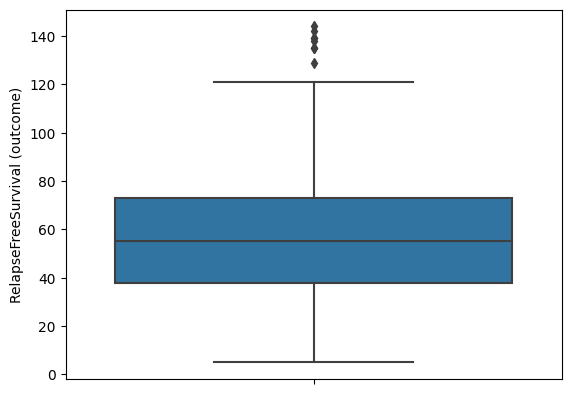

In [71]:
# countplot and boxplot for both classification and regression outcome
sns.boxplot(y='RelapseFreeSurvival (outcome)', data=all_df)

#### Data imputation

- Dropping rows which has several missing values

In [72]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index).tolist()
missing_values_index = set(missing_values_index[0])

drop_index = []
for index in missing_values_index:
    missing_values_rows = all_df.iloc[index]
    missing_values_rows = np.array(missing_values_rows).tolist()
    if missing_values_rows.count(999) >= 3:
        drop_index.append(index)

all_df = all_df.drop(drop_index)

# retain the original dataset with ID column to be used in the future
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

- Using multivariate imputer

In [73]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])

# convert to dataFrame
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# get the target and features dataframe
regression_target = multi_imputed_df['RelapseFreeSurvival (outcome)']
regression_features = multi_imputed_df.drop(['RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1)

## Feature selection

### Univariate feature selection

In [74]:
features_to_be_selected = 20

- Using f_regression

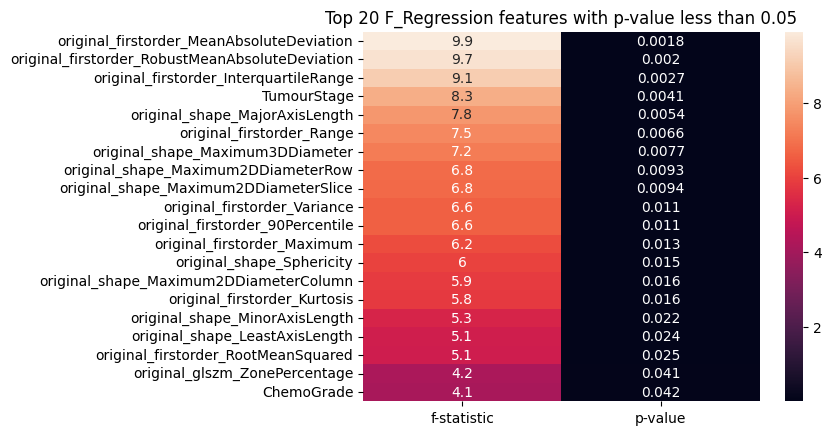

In [75]:
f, p_val = f_regression(regression_features, regression_target)
f_reg_df = pd.DataFrame(np.array([f, p_val]).T, index=regression_features.columns, columns=['f-statistic', 'p-value'])
binary_stored_features = f_reg_df[f_reg_df['p-value'] <= 0.05].sort_values(by='f-statistic', ascending=False).head(
    features_to_be_selected)
sns.heatmap(data=binary_stored_features, annot=True)
plt.title(f'Top {len(binary_stored_features)} F_Regression features with p-value less than 0.05')
plt.show()
binary_stored_features = binary_stored_features.head(11)

- Using mutual_info_regression

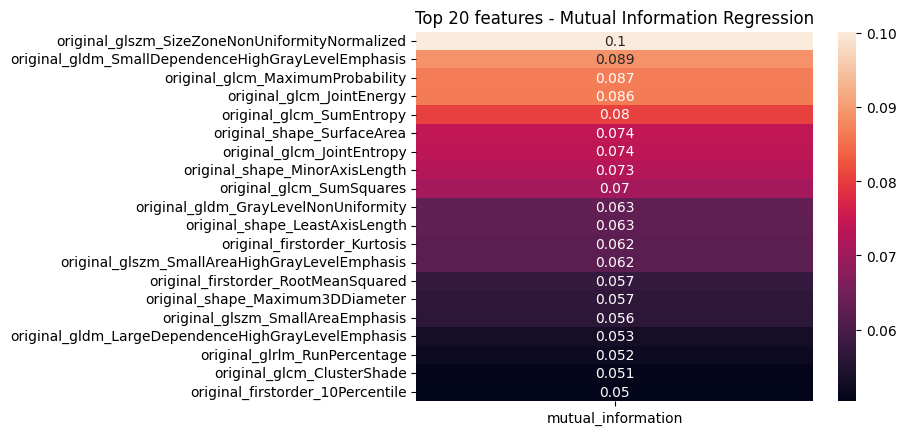

In [76]:
mi = mutual_info_regression(regression_features, regression_target, random_state=42)
mi_df = pd.DataFrame(mi, index=regression_features.columns, columns=['mutual_information'])
mi_top_features = mi_df.sort_values(by=['mutual_information'], ascending=False).head(features_to_be_selected)
sns.heatmap(mi_top_features, annot=True)
plt.title(f'Top {features_to_be_selected} features - Mutual Information Regression')
plt.show()
mi_top_features = mi_top_features.head(3)

### Model-based selection

- Using Random Forest Regressor

In [77]:
# hyperparameter tuning for random forest
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, param_grid={
    'n_estimators': np.arange(200, 500, 100).tolist(),
    'max_features': ['sqrt'],
    'random_state': [42],
    'criterion': ['absolute_error'],
    'max_depth': np.arange(5, 15, 1).tolist()}, scoring='neg_mean_absolute_error')
rf_search.fit(regression_features, regression_target)
print("Best params for Random Forest Regressor: ", rf_search.best_params_)
print("Best parameter (Cross-validation MAE): ", rf_search.best_score_, "\n")

Best params for Random forest regressor:  {'criterion': 'absolute_error', 'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
Best parameter (CV MAE): -22.147691758966246 



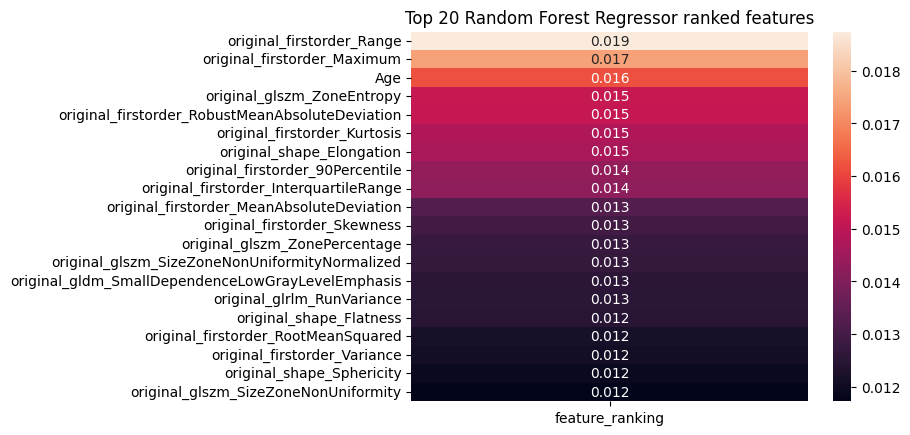

In [78]:
# rank features using random forest
rf = make_pipeline(StandardScaler(),
                   RandomForestRegressor().set_params(**rf_search.best_params_))
rf.fit(regression_features, regression_target)
rf_features = pd.DataFrame(rf.steps[1][1].feature_importances_, index=regression_features.columns,
                           columns=['feature_ranking'])
selected_rf_features = rf_features.sort_values(by=['feature_ranking'], ascending=False).head(features_to_be_selected)
sns.heatmap(data=selected_rf_features, annot=True)
plt.title('Top 20 Random Forest Regressor ranked features')
plt.show()
selected_rf_features = selected_rf_features.head(11)

### Select features based on different methods

In [86]:
selected_features = np.concatenate(
    (binary_stored_features.index.values, selected_rf_features.index.values, mi_top_features.index.values))
selected_features = set(selected_features)

top_features = regression_features[selected_features]

20


## Modelling & Evaluation

In [80]:
X_train, X_test, y_train, y_test = train_test_split(top_features, regression_target, test_size=0.3, random_state=42)

- Using SVM

In [81]:
top_features_svr = make_pipeline(StandardScaler(), SVR())
top_features_svr_search = GridSearchCV(top_features_svr,
                                       param_grid={'svr__C': np.arange(0, 10, 0.1).tolist(),
                                                   'svr__epsilon': np.arange(0, 3, 0.1).tolist()},
                                       scoring='neg_mean_absolute_error',
                                       )
top_features_svr_search.fit(X_train, y_train)
print("Best params for SVR: ", top_features_svr_search.best_params_)
print("Best parameter (Cross-validation MAE): ", top_features_svr_search.best_score_, "\n")

grid_keys = list(top_features_svr_search.best_params_.keys())
param_keys = [param.replace('svr__', '') for param in grid_keys]
grid_values = list(top_features_svr_search.best_params_.values())
param_dict = {k: v for k, v in zip(param_keys, grid_values)}

top_features_svr = make_pipeline(StandardScaler(), SVR().set_params(**param_dict))
top_features_svr.fit(X_train, y_train)
print("Mean absolute error for svm training score: ",
      mean_absolute_error(y_train, top_features_svr.predict(X_train)))
print("Mean absolute error for svm test score: ",
      mean_absolute_error(y_test, top_features_svr.predict(X_test)))
print("Mean absolute error for svm cross-validation score: ",
      np.mean(cross_val_score(top_features_svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)))

Best params for SVR:  {'svr__C': 4.7, 'svr__epsilon': 1.2000000000000002}
Best parameter (CV MAE): -19.363132471253074 

Mean absolute error for svm:  17.61028311943751
Mean absolute error for svm:  23.022235313660037
-19.363132471253074


- Using Lasso

In [82]:
lasso = make_pipeline(StandardScaler(), Lasso())
lasso_search = GridSearchCV(lasso, param_grid={'lasso__alpha': np.arange(0, 10000, 100).tolist()},
                            scoring='neg_mean_absolute_error')
lasso_search.fit(X_train, y_train)
print("Best params for Lasso Regression: ", lasso_search.best_params_)
print("Best parameter (Cross-validation MAE): ", lasso_search.best_score_, "\n")

grid_keys = list(lasso_search.best_params_.keys())
param_keys = [param.replace('lasso__', '') for param in grid_keys]
grid_values = list(lasso_search.best_params_.values())
param_dict = {k: v for k, v in zip(param_keys, grid_values)}

lasso = make_pipeline(StandardScaler(), Lasso().set_params(**param_dict))
lasso.fit(X_train, y_train)
print("Mean absolute error for Lasso Regression training score: ",
      mean_absolute_error(y_train, lasso.predict(X_train)))
print("Mean absolute error for Lasso Regression test score: ",
      mean_absolute_error(y_test, lasso.predict(X_test)))
print("Mean absolute error for Lasso Regression cross-validation score: ",
      np.mean(cross_val_score(lasso, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)))

Best params for Lasso Regression:  {'lasso__alpha': 100}
Best parameter (CV MAE): -19.881346769729124 

Mean absolute error for Lasso Regression:  19.830922250170513
Mean absolute error for Lasso Regression::  22.93277426795026
-19.881346769729124


- Using Random Forest Regressor

In [83]:
top_features_rr = make_pipeline(StandardScaler(), RandomForestRegressor())
top_features_rr_search = GridSearchCV(top_features_rr, param_grid={
    'randomforestregressor__n_estimators': np.arange(200, 500, 100).tolist(),
    'randomforestregressor__max_features': ['sqrt', 'auto', 'log2'],
    'randomforestregressor__random_state': [42],
    'randomforestregressor__criterion': ['absolute_error'],
    'randomforestregressor__max_depth': np.arange(5, 15, 1).tolist()}, verbose=3, scoring='neg_mean_absolute_error')
top_features_rr_search.fit(X_train, y_train)
print("Best params for Random Forest Regressor: ", top_features_rr_search.best_params_)
print("Best parameter (Cross-validation MAE): ", top_features_rr_search.best_score_, "\n")

grid_keys = list(top_features_rr_search.best_params_.keys())
param_keys = [param.replace('randomforestregressor__', '') for param in grid_keys]
grid_values = list(top_features_rr_search.best_params_.values())
param_dict = {k: v for k, v in zip(param_keys, grid_values)}

top_features_rr = make_pipeline(StandardScaler(),
                                RandomForestRegressor().set_params(**param_dict))
top_features_rr.fit(X_train, y_train)
print("Mean absolute error for random forest training score: ",
      mean_absolute_error(y_train, top_features_rr.predict(X_train)))
print("Mean absolute error for random forest test score: ",
      mean_absolute_error(y_test, top_features_rr.predict(X_test)))
print("Mean absolute error for random forest cross-validation score: ", np.mean(cross_val_score(top_features_rr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-20.916 total time=   0.3s
[CV 2/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-18.858 total time=   0.3s
[CV 3/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-17.881 total time=   0.3s
[CV 4/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimato

## Final modelling using the entire dataset

In [84]:
rf = RandomForestRegressor().set_params(**param_dict)
Xs = StandardScaler().fit_transform(top_features)
rf.fit(Xs, regression_target)

RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features='sqrt', n_estimators=400, random_state=42)

### Save Random Forest Regressor model with pickle

In [85]:
with open("RandomForestRegressor.pickle", "wb") as f:
    pickle.dump(rf, f)